# Daily Model Development

In [21]:
############### Initialize ###################

# Basics
from pymongo import MongoClient
import os
import numpy as np
import pandas as pd
import time
import boto3
import io
import warnings
warnings.filterwarnings('ignore')

# NLP
import nltk
import spacy
spacy.load('en')
from nltk.corpus import stopwords
import preprocessor as p

# Model Infrastructure
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.pipeline import make_pipeline, Pipeline, FeatureUnion
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn import metrics

# Models
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn import linear_model
import xgboost as xgb
from xgboost.sklearn import XGBClassifier, XGBRegressor
from sklearn.naive_bayes import BernoulliNB

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
###################### Bring In Data #######################
#Setup Mongo and create the database and collection
User = os.environ['MONGODB_USER']
password = os.environ['MONGODB_PASS']
IP = os.environ['IP']

client = MongoClient(IP, username=User, password=password)
db = client['stock_tweets']

#Grab references
twitter_coll_reference = db.twitter
iex_coll_reference = db.iex

In [3]:
###################### Build Twitter Data Frames #####################

start_time = time.time()
# Create Data Frame
twitter_data = pd.DataFrame(list(twitter_coll_reference.find()))

# Need to convert the created_at to a time stamp and set to index
twitter_data.index=pd.to_datetime(twitter_data['created_at'])

# Delimited the Company List into separate rows
delimited_twitter_data=[]

for item in twitter_data.itertuples():
    #twitter_dict={}
    for company in item[1]:
        twitter_dict={}
        twitter_dict['created_at']=item[0]
        twitter_dict['company']=company
        twitter_dict['text']=item[11]
        twitter_dict['user_followers_count']=item[12]
        twitter_dict['user_name']=item[13]
        twitter_dict['user_statuses_count']=item[15]
        delimited_twitter_data.append(twitter_dict)

delimited_twitter_df = pd.DataFrame(delimited_twitter_data) 
delimited_twitter_df.set_index('created_at', inplace=True)

# Create hourly data frame
twitter_delimited_hourly = delimited_twitter_df.groupby([pd.Grouper(freq="D"), 'company']).count()['text'].to_frame()
twitter_delimited_hourly.columns = ['Number_of_Tweets']

# Concatenate the text with a space to not combine words.
twitter_delimited_hourly['text']=delimited_twitter_df.groupby([pd.Grouper(freq="D"), 'company'])['text'].apply(lambda x: ' '.join(x))
# Number of Users
twitter_delimited_hourly['Number_of_Users'] = delimited_twitter_df.groupby([pd.Grouper(freq="D"), 'company'])['user_name'].nunique()

# Rename Index
twitter_delimited_hourly = twitter_delimited_hourly.reindex(twitter_delimited_hourly.index.rename(['Time', 'Company']))

print("-- Execution time: %s seconds ---" % (time.time() - start_time))

-- Execution time: 32.18883395195007 seconds ---


In [4]:
##################### Build Stock Data Frames ###########################
start_time = time.time()

stock_data = pd.DataFrame(list(iex_coll_reference.find()))

# Need to convert the created_at to a time stamp
stock_data.index=pd.to_datetime(stock_data['latestUpdate'])
stock_data['latestUpdate'] = pd.to_datetime(stock_data['latestUpdate'])
#Group By hourly and stock price
# Need to get the first stock price in teh hour, and then the last to take the difference to see how much change.
stock_delimited_hourly = stock_data.sort_values('latestUpdate').groupby([pd.Grouper(freq="D"), 'Ticker']).first()['latestPrice'].to_frame()
stock_delimited_hourly.columns = ['First_Price']
stock_delimited_hourly['Last_Price'] = stock_data.sort_values('latestUpdate').groupby([pd.Grouper(freq="D"), 'Ticker']).last()['latestPrice']

# Then need to take the difference and turn into a percentage.
stock_delimited_hourly['Price_Percent_Change'] = ((stock_delimited_hourly['Last_Price'] 
                                                   - stock_delimited_hourly['First_Price'])/stock_delimited_hourly['First_Price'])*100

# Need to also show Percent from open price
stock_delimited_hourly['Open_Price'] = stock_data.groupby([pd.Grouper(freq="D"), 'Ticker'])['open'].mean()
stock_delimited_hourly['Price_Percent_Open'] = ((stock_delimited_hourly['Last_Price'] 
                                                 - stock_delimited_hourly['Open_Price'])/stock_delimited_hourly['Open_Price'])*100

# Also include mean volume
stock_delimited_hourly['Mean_Volume'] = stock_data.groupby([pd.Grouper(freq="D"), 'Ticker'])['latestVolume'].mean()

# Classification Labels
stock_delimited_hourly['Price_Change'] = np.where(stock_delimited_hourly['Price_Percent_Change']>=0, 1, 0)
stock_delimited_hourly['Open_Price_Change'] = np.where(stock_delimited_hourly['Price_Percent_Open']>=0, 1, 0)

# Rename the Index
stock_delimited_hourly = stock_delimited_hourly.reindex(stock_delimited_hourly.index.rename(['Time', 'Company']))
print("-- Execution time: %s seconds ---" % (time.time() - start_time))

-- Execution time: 10.612527132034302 seconds ---


In [5]:
######################### Combine Data Frames ##############################
daily_df = pd.concat([twitter_delimited_hourly, stock_delimited_hourly], axis=1, join='inner')
daily_df.head()

Number_of_Tweets  \
Time       Company                     
2018-03-12 AAPL                  403   
           AMZN                  275   
           BA                    137   
           BABA                   50   
           BAC                    51   

                                                                 text  \
Time       Company                                                      
2018-03-12 AAPL     @JoKiddo But how proprietary is that? Does it ...   
           AMZN     Amazon hits $1600 $AMZN Americans reported one...   
           BA       Thus, its cheaper for $AAPL to built than to b...   
           BABA     Thus, its cheaper for $AAPL to built than to b...   
           BAC      Open an account with @RobinhoodApp and get a s...   

                    Number_of_Users  First_Price  Last_Price  \
Time       Company                                             
2018-03-12 AAPL                 258      181.730      181.75   
           AMZN                 162     1600.745     1598.39   
           BA                    94      345.910      344.19   
           BABA                  37      192.900      192.74   
           BAC                   35       32.980       32.84   

                    Price_Percent_Change  Open_Price  Price_Percent_Open  \
Time       Company                                                         
2018-03-12 AAPL                 0.011005      180.23            0.843367   
           AMZN                -0.147119     1592.60            0.363556   
           BA                  -0.497239      355.02           -3.050532   
           BABA                -0.082945      192.00            0.385417   
           BAC                 -0.424500       32.67            0.520355   

                     Mean_Volume  Price_Change  Open_Price_Change  
Time       Company                                                 
2018-03-12 AAPL     2.767373e+07             1                  1  
           AMZN     4.376277e+06             0                  1  
           BA       5.150044e+06             0                  0  
           BABA     1.622245e+07             0                  1  
           BAC      4.670738e+07             0                  1

In [6]:
# To flatten after combined everything. 
daily_df.reset_index(inplace=True)


In [8]:
# Clean the Tweets
p.set_options(p.OPT.URL, p.OPT.EMOJI, p.OPT.MENTION, p.OPT.RESERVED, p.OPT.EMOJI, p.OPT.HASHTAG)
def preprocess_tweet(tweet):
    return p.clean(tweet)

# Clean the tweets, by removing special characters
start_time = time.time()
daily_df['Clean_text'] = daily_df['text'].apply(lambda x: preprocess_tweet(x))
print("-- Execution time: %s seconds ---" % (time.time() - start_time))

-- Execution time: 4.344789028167725 seconds ---


In [9]:
# Split Between Outcome and Features
features = daily_df[['Company','Number_of_Tweets', 'Number_of_Users','Mean_Volume','Clean_text']]
classification_price = daily_df['Price_Change']
classification_open = daily_df['Open_Price_Change']
regression_price = daily_df['Price_Percent_Change']
regression_open = daily_df['Price_Percent_Open']

In [10]:
# Want to leverage the Company name so need to create dummy variables. 
cat_feats = ['Company']
features = pd.get_dummies(features, columns=cat_feats, drop_first=True)
features.head()

,Number_of_Tweets,Number_of_Users,Mean_Volume,Clean_text,Company_AMZN,Company_BA,Company_BABA,Company_BAC,Company_C,Company_CMCSA,...,Company_NFLX,Company_NVDA,Company_PFE,Company_TSLA,Company_TWTR,Company_UNH,Company_UTX,Company_V,Company_WFC,Company_XOM
0,403,258,2.767373e+07,But how proprietary is that? Does it really ma...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,275,162,4.376277e+06,Amazon hits $1600 $AMZN Americans reported one...,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,137,94,5.150044e+06,"Thus, its cheaper for $AAPL to built than to b...",0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,50,37,1.622245e+07,"Thus, its cheaper for $AAPL to built than to b...",0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,51,35,4.670738e+07,Open an account with and get a stock like $HPQ...,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
# Will create pipeline that combines all the steps and then apply the model at the end.
# Since all the features are apart of the features dataframe, for the NLP only need the clean text, but still want to add other things.

# Will create a class to handle this. 
class DataSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        
    def fit(self, x, y=None):
        return self
    
    def transform(self, features):
        if self.key=='text':
            return features['Clean_text']
        else:
            return features.loc[:, features.columns != 'Clean_text']

## Classification

### Price Change

In [12]:
# Check is Data is imbalanced
daily_df['Price_Change'].value_counts()

0    661
1    527
Name: Price_Change, dtype: int64

In [27]:
# Split the Data to avoid Leakage
#splitting into training and test sets
X_train, X_test, y_train, y_test = train_test_split(features,classification_price,test_size=0.2)

In [28]:
# Check to see how much variance is being explained
# 152113 Features

# 500 Components Explains 0.858 in 54 seconds
# 1000 components explains 1.0 in 88 seconds
# 750 components explains 0.969 in 70 seconds
X = X_train['Clean_text']

start_time = time.time()
# Create lemmatizer using spacy
lemmatizer = spacy.lang.en.English()

def custom_tokenizer(doc):
    tokens = lemmatizer(doc)
    return([token.lemma_ for token in tokens if not token.is_punct])

vectorizer = TfidfVectorizer(tokenizer=custom_tokenizer, stop_words='english',
                             lowercase=True, use_idf=True, max_df=0.5, 
                             min_df=2, norm='l2', smooth_idf=True, ngram_range=(1, 2))

tweets_tfidf = vectorizer.fit_transform(X)
print("Vectorizing Finished. Number of features: %d" % tweets_tfidf.get_shape()[1])
pipe = Pipeline(steps=[
                 ('svd', TruncatedSVD(750)),
                 ('norm',Normalizer(copy=False))
                       ])

pipe.fit_transform(tweets_tfidf)
print("Explained Variance: " + str(pipe.get_params()['svd'].explained_variance_ratio_.sum()))
print("-- Execution time: %s seconds ---" % (time.time() - start_time))

Vectorizing Finished. Number of features: 152113
Explained Variance: 0.9692198227304989
-- Execution time: 70.19580101966858 seconds ---


In [28]:
####### Logistic Regression ############

start_time = time.time()
# Create lemmatizer using spacy
lemmatizer = spacy.lang.en.English()

# Define Model
lr_model = LogisticRegression(n_jobs=5)

# Define custom Tokenizer
def custom_tokenizer(doc):
    tokens = lemmatizer(doc)
    return([token.lemma_ for token in tokens if not token.is_punct])

# Define Vectorizer
vectorizer = TfidfVectorizer(tokenizer=custom_tokenizer, stop_words='english',
                             lowercase=True, use_idf=True, max_df=2,
                             min_df=2, norm='l2', smooth_idf=True, ngram_range=(1, 2))

# Define Pipeline and Feature Union
pipeline = Pipeline([
    # Use Feature Union to combine features from the Tweet and other features gathered
    ('union', FeatureUnion(
        transformer_list=[
            # Pipeline for text
            ('tweet', Pipeline([
                ('selector', DataSelector(key='text')),
                ('vectidf', vectorizer),
                ('svd', TruncatedSVD(1000)),
                ('norm',Normalizer(copy=False))
                                
            ])),
            
            # Pipeline for getting other features
            ('other', Pipeline([
                ('seclector', DataSelector(key='other'))
             ])),
        ],
                       
    )),
    # Use Logistic Regression Classifier
    ('lr', lr_model)
])

# Grid Search
parameters = {
                'lr__penalty':['l1'],
                'lr__C':[10],
                'lr__class_weight':['balanced'],
                #'lr__solver':['newton-cg'],
                'union__transformer_weights':[{'tweet':0.7, 'other':0.3}]
               
              }

grid = GridSearchCV(pipeline, parameters, scoring='f1', cv=2, verbose=0, n_jobs=10)

# Fit the grid
grid.fit(X_train, y_train)
# Predictions
y = grid.predict(X_test)
print("-- Execution time: %s seconds ---" % (time.time() - start_time))
print(classification_report(y, y_test))

-- Execution time: 95.42401885986328 seconds ---
             precision    recall  f1-score   support

          0       0.68      0.73      0.70       121
          1       0.70      0.65      0.67       117

avg / total       0.69      0.69      0.69       238



In [17]:
grid.best_params_

{'lr__C': 10,
 'lr__class_weight': 'balanced',
 'lr__penalty': 'l2',
 'lr__solver': 'newton-cg',
 'union__transformer_weights': {'other': 0.3, 'tweet': 0.7}}

In [29]:
# AUROC Score
prediction_proba = grid.predict_proba(X_test)
prediction_proba = [p[1] for p in prediction_proba]
print(roc_auc_score(y_test, prediction_proba))

0.7394922125026671


In [63]:
####### Naive Bayes ############

start_time = time.time()
# Create lemmatizer using spacy
lemmatizer = spacy.lang.en.English()

# Define Model
bnb_model = BernoulliNB()

# Define custom Tokenizer
def custom_tokenizer(doc):
    tokens = lemmatizer(doc)
    return([token.lemma_ for token in tokens if not token.is_punct])

# Define Vectorizer
vectorizer = TfidfVectorizer(tokenizer=custom_tokenizer, stop_words='english',
                             lowercase=True, use_idf=True, max_df=2,
                             min_df=2, norm='l2', smooth_idf=True, ngram_range=(1, 2))

# Define Pipeline and Feature Union
pipeline = Pipeline([
    # Use Feature Union to combine features from the Tweet and other features gathered
    ('union', FeatureUnion(
        transformer_list=[
            # Pipeline for text
            ('tweet', Pipeline([
                ('selector', DataSelector(key='text')),
                ('vectidf', vectorizer),
                ('svd', TruncatedSVD(1000)),
                ('norm',Normalizer(copy=False))
                                
            ])),
            
            # Pipeline for getting other features
            ('other', Pipeline([
                ('seclector', DataSelector(key='other'))
             ])),
        ],
                       
    )),
    # Use Logistic Regression Classifier
    ('bnb', bnb_model)
])

# Grid Search
parameters = {
                
                
                'union__transformer_weights':[{'tweet':0.5, 'other':0.5},{'tweet':0.2, 'other':0.8},{'tweet':0.8, 'other':0.2}]
               
              }

grid = GridSearchCV(pipeline, parameters, scoring='accuracy', cv=3, verbose=0, n_jobs=5)

# Fit the grid
grid.fit(X_train, y_train)
# Predictions
y = grid.predict(X_test)
print("-- Execution time: %s seconds ---" % (time.time() - start_time))
print(classification_report(y, y_test))

-- Execution time: 165.06213784217834 seconds ---
             precision    recall  f1-score   support

          0       0.57      0.59      0.58       121
          1       0.56      0.54      0.55       117

avg / total       0.56      0.56      0.56       238



In [37]:
####### Random Forest ############

start_time = time.time()
# Create lemmatizer using spacy
lemmatizer = spacy.lang.en.English()

# Define Model
rfc_model = RandomForestClassifier(n_jobs=10)

# Define custom Tokenizer
def custom_tokenizer(doc):
    tokens = lemmatizer(doc)
    return([token.lemma_ for token in tokens if not token.is_punct])

# Define Vectorizer
vectorizer = TfidfVectorizer(tokenizer=custom_tokenizer, stop_words='english',
                             lowercase=True, use_idf=True, max_df=2,
                             min_df=2, norm='l2', smooth_idf=True, ngram_range=(1, 2))

# Define Pipeline and Feature Union
pipeline = Pipeline([
    # Use Feature Union to combine features from the Tweet and other features gathered
    ('union', FeatureUnion(
        transformer_list=[
            # Pipeline for text
            ('tweet', Pipeline([
                ('selector', DataSelector(key='text')),
                ('vectidf', vectorizer),
                ('svd', TruncatedSVD(1000)),
                ('norm',Normalizer(copy=False))
                                
            ])),
            
            # Pipeline for getting other features
            ('other', Pipeline([
                ('seclector', DataSelector(key='other'))
             ])),
        ],
                       
    )),
    # Use Logistic Regression Classifier
    ('rfc', rfc_model)
])

# Grid Search
parameters = {
                
                'rfc__class_weight':['balanced'],
                'union__transformer_weights':[{'tweet':0.5, 'other':0.5},{'tweet':0.2, 'other':0.8},{'tweet':0.8, 'other':0.2}]
               
              }

grid = GridSearchCV(pipeline, parameters, scoring='accuracy', cv=3, verbose=0, n_jobs=5)

# Fit the grid
grid.fit(X_train, y_train)
# Predictions
y = grid.predict(X_test)
print("-- Execution time: %s seconds ---" % (time.time() - start_time))
print(classification_report(y, y_test))

-- Execution time: 163.80610704421997 seconds ---
             precision    recall  f1-score   support

          0       0.74      0.55      0.63       167
          1       0.34      0.54      0.41        71

avg / total       0.62      0.55      0.57       238



In [38]:
grid.best_params_

{'rfc__class_weight': 'balanced',
 'union__transformer_weights': {'other': 0.5, 'tweet': 0.5}}

In [40]:
####### SGD ############

start_time = time.time()
# Create lemmatizer using spacy
lemmatizer = spacy.lang.en.English()

# Define Model
sgd_model = linear_model.SGDClassifier(n_jobs=10)

# Define custom Tokenizer
def custom_tokenizer(doc):
    tokens = lemmatizer(doc)
    return([token.lemma_ for token in tokens if not token.is_punct])

# Define Vectorizer
vectorizer = TfidfVectorizer(tokenizer=custom_tokenizer, stop_words='english',
                             lowercase=True, use_idf=True, max_df=2,
                             min_df=2, norm='l2', smooth_idf=True, ngram_range=(1, 2))

# Define Pipeline and Feature Union
pipeline = Pipeline([
    # Use Feature Union to combine features from the Tweet and other features gathered
    ('union', FeatureUnion(
        transformer_list=[
            # Pipeline for text
            ('tweet', Pipeline([
                ('selector', DataSelector(key='text')),
                ('vectidf', vectorizer),
                ('svd', TruncatedSVD(1000)),
                ('norm',Normalizer(copy=False))
                                
            ])),
            
            # Pipeline for getting other features
            ('other', Pipeline([
                ('seclector', DataSelector(key='other'))
             ])),
        ],
                       
    )),
    # Use Logistic Regression Classifier
    ('sgd', sgd_model)
])

# Grid Search
parameters = {
                
                'sgd__loss':['log'],
                'sgd__penalty':['l2'],
                'sgd__fit_intercept':[True],
                'sgd__class_weight':['balanced'],
                'union__transformer_weights':[{'tweet':0.5, 'other':0.5},{'tweet':0.2, 'other':0.8},{'tweet':0.8, 'other':0.2}]
               
              }

grid = GridSearchCV(pipeline, parameters, scoring='accuracy', cv=3, verbose=0, n_jobs=5)

# Fit the grid
grid.fit(X_train, y_train)
# Predictions
y = grid.predict(X_test)
print("-- Execution time: %s seconds ---" % (time.time() - start_time))
print(classification_report(y, y_test))

-- Execution time: 162.1376187801361 seconds ---
             precision    recall  f1-score   support

          0       0.00      0.00      0.00         0
          1       1.00      0.47      0.64       238

avg / total       1.00      0.47      0.64       238



In [46]:
####### XGB ############
warnings.filterwarnings('ignore')
start_time = time.time()
# Create lemmatizer using spacy
lemmatizer = spacy.lang.en.English()

# Define Model
xgb_model = XGBClassifier(learning_rate =0.1, 
                          max_depth=5, 
                          min_child_weight=1, 
                          gamma=0, 
                          subsample=0.8, 
                          colsample_bytree=0.8, 
                          objective= 'binary:logistic', 
                          scale_pos_weight=1) 


# Define custom Tokenizer
def custom_tokenizer(doc):
    tokens = lemmatizer(doc)
    return([token.lemma_ for token in tokens if not token.is_punct])

# Define Vectorizer
vectorizer = TfidfVectorizer(tokenizer=custom_tokenizer, stop_words='english',
                             lowercase=True, use_idf=True, max_df=2,
                             min_df=2, norm='l2', smooth_idf=True, ngram_range=(1, 2))

# Define Pipeline and Feature Union
pipeline = Pipeline([
    # Use Feature Union to combine features from the Tweet and other features gathered
    ('union', FeatureUnion(
        transformer_list=[
            # Pipeline for text
            ('tweet', Pipeline([
                ('selector', DataSelector(key='text')),
                ('vectidf', vectorizer),
                ('svd', TruncatedSVD(1000)),
                ('norm',Normalizer(copy=False))
                                
            ])),
            
            # Pipeline for getting other features
            ('other', Pipeline([
                ('seclector', DataSelector(key='other'))
             ])),
        ],
                       
    )),
    # Use Logistic Regression Classifier
    ('xgb', xgb_model)
])

# Grid Search
parameters = {
                
                'xgb__n_jobs':[20],
                'xgb__n_estimators':range(100,1000,200),
                'union__transformer_weights':[{'tweet':0.7, 'other':0.3}]
               
              }

grid = GridSearchCV(pipeline, parameters, scoring='accuracy', cv=3, verbose=0, n_jobs=5)

# Fit the grid
grid.fit(X_train, y_train)
# Predictions
y = grid.predict(X_test)
print("-- Execution time: %s seconds ---" % (time.time() - start_time))
print(classification_report(y, y_test))

-- Execution time: 298.4327247142792 seconds ---
             precision    recall  f1-score   support

          0       0.72      0.64      0.68       140
          1       0.56      0.64      0.60        98

avg / total       0.65      0.64      0.65       238



In [47]:
grid.best_params_

{'union__transformer_weights': {'other': 0.3, 'tweet': 0.7},
 'xgb__n_estimators': 100,
 'xgb__n_jobs': 20}

## Regression

In [22]:
# Split the Data to avoid Leakage
#splitting into training and test sets
X_train, X_test, y_train, y_test = train_test_split(features,regression_price,test_size=0.2)

In [75]:
####### SGD ############

start_time = time.time()
# Create lemmatizer using spacy
lemmatizer = spacy.lang.en.English()

# Define Model
sgd_model = linear_model.SGDRegressor(loss='squared_loss')

# Define custom Tokenizer
def custom_tokenizer(doc):
    tokens = lemmatizer(doc)
    return([token.lemma_ for token in tokens if not token.is_punct])

# Define Vectorizer
vectorizer = TfidfVectorizer(tokenizer=custom_tokenizer, stop_words='english',
                             lowercase=True, use_idf=True, max_df=2,
                             min_df=2, norm='l2', smooth_idf=True, ngram_range=(1, 2))

# Define Pipeline and Feature Union
pipeline = Pipeline([
    # Use Feature Union to combine features from the Tweet and other features gathered
    ('union', FeatureUnion(
        transformer_list=[
            # Pipeline for text
            ('tweet', Pipeline([
                ('selector', DataSelector(key='text')),
                ('vectidf', vectorizer),
                ('svd', TruncatedSVD(1000)),
                ('norm',Normalizer(copy=False))
                                
            ])),
            
            # Pipeline for getting other features
            ('other', Pipeline([
                ('seclector', DataSelector(key='other'))
             ])),
        ],
                       
    )),
    # Use Logistic Regression Classifier
    ('sgd', sgd_model)
])

# Grid Search
parameters = {
                'sgd__penalty':['l1','l2'],
                'sgd__alpha':[0.001, 0.01, 0.1],
                'union__transformer_weights':[{'tweet':0.7, 'other':0.3}]
               
              }

grid = GridSearchCV(pipeline, parameters, scoring='neg_mean_squared_error', cv=2, verbose=0, n_jobs=5)

# Fit the grid
grid.fit(X_train, y_train)

# Score

print("-- Execution time: %s seconds ---" % (time.time() - start_time))
print(grid.score(X_test, y_test))

-- Execution time: 185.0781111717224 seconds ---
-7.497765288435067e+42


In [69]:
grid.best_params_

{'sgd__alpha': 0.01,
 'sgd__penalty': 'l2',
 'union__transformer_weights': {'other': 0.2, 'tweet': 0.8}}

In [76]:
predictions = grid.predict(X_test)

print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))

MAE: 1.7984166828644368e+21
MSE: 7.497765288435067e+42
RMSE: 2.738204756484633e+21


In [ ]:
plt.scatter(y_test,predictions)

In [ ]:
sns.distplot((y_test-predictions),bins=50);

In [23]:
####### Random Forest ############

start_time = time.time()
# Create lemmatizer using spacy
lemmatizer = spacy.lang.en.English()

# Define Model
rf_model = rfc_model = RandomForestRegressor()

# Define custom Tokenizer
def custom_tokenizer(doc):
    tokens = lemmatizer(doc)
    return([token.lemma_ for token in tokens if not token.is_punct])

# Define Vectorizer
vectorizer = TfidfVectorizer(tokenizer=custom_tokenizer, stop_words='english',
                             lowercase=True, use_idf=True, max_df=2,
                             min_df=2, norm='l2', smooth_idf=True, ngram_range=(1, 2))

# Define Pipeline and Feature Union
pipeline = Pipeline([
    # Use Feature Union to combine features from the Tweet and other features gathered
    ('union', FeatureUnion(
        transformer_list=[
            # Pipeline for text
            ('tweet', Pipeline([
                ('selector', DataSelector(key='text')),
                ('vectidf', vectorizer),
                ('svd', TruncatedSVD(1000)),
                ('norm',Normalizer(copy=False))
                                
            ])),
            
            # Pipeline for getting other features
            ('other', Pipeline([
                ('seclector', DataSelector(key='other'))
             ])),
        ],
                       
    )),
    # Use Random Forest Regressor
    ('rfr', rf_model)
])

# Grid Search
parameters = {
                
                'union__transformer_weights':[{'tweet':0.7, 'other':0.3}]
               
              }

grid = GridSearchCV(pipeline, parameters, scoring='neg_mean_squared_error', cv=2, verbose=0, n_jobs=5)

# Fit the grid
grid.fit(X_train, y_train)

# Score

print("-- Execution time: %s seconds ---" % (time.time() - start_time))
print(grid.score(X_test, y_test))

-- Execution time: 92.43107724189758 seconds ---
-3.0045429281904665


In [24]:
predictions = grid.predict(X_test)

print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))

MAE: 1.2655067297212452
MSE: 3.0045429281904665
RMSE: 1.7333617418734228


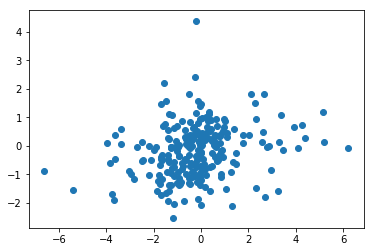

In [25]:
plt.scatter(y_test,predictions)

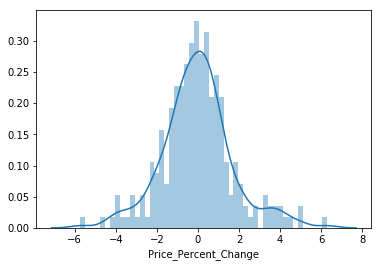

In [26]:
sns.distplot((y_test-predictions),bins=50);